In [6]:
#!/usr/bin/env python

__author__ = 'Jonas Bickel'
__copyright__ = 'Copyright 2019'
__license__ = 'GNU GPLv3'
__version__ = '0.0.1'
__email__ = 'jonas.bickel@t-online.de'
__status__ = "Development"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [7]:
index_name = 'test' # Required for module 1
base_value = 100

start_date = 200 #(1 * 252)
end_date = (-200)

### Inactive variables for later updates
base_date = None
index_composition_matrix = None
number_stocks = 0
included_number_stocks = 0
###

In [8]:
# Module 1
# Create price data matrix from Yahoo! Finance Data and adding market capitalization

def create_index_composition_matrix(folder_name=index_name, add_market_cap_col=True):
    ''' Create list object (called 'index_composition_matrix') containing stocks defined in list_stocks.csv 
    and their respective pricing data as DataFrames'''
    
    # 1. Define file locations
    loc_main_folder = folder_name
    loc_list_stocks = loc_main_folder + '/list_stocks.csv'
    loc_list_shares_outstanding = loc_main_folder + '/list_shares_outstanding.csv'
    loc_stock_data = loc_main_folder + '/stock_data/'
    
    # 2. Create a list of stock symbols defined in the list_stock.csv file
    global index_components
    index_components = pd.read_csv(loc_list_stocks, header=None)
    index_components = index_components.values.T[0].tolist()
    
    # 3. Create a list of shares outstanding defined in the list_shares_outstanding.csv file
    global shares_outstanding
    shares_outstanding = pd.read_csv(loc_list_shares_outstanding, header=None)
    shares_outstanding = shares_outstanding.values.T[0].tolist()
    
    # 4. Check sums
    if len(shares_outstanding) != len(index_components):
        print("Number of entries in list_stocks.csv and list_shares_outstanding.csv is not equal.")
        
    # For index calculation
    global number_stocks
    number_stocks = len(index_components)

    # 5. Create list object with index components via Yahoo! Finance CSV files        
    global index_composition_matrix
    index_composition_matrix = list()
    
    for i in index_components:
        index_composition_matrix.append(pd.read_csv(loc_stock_data+i.upper().replace("_",".")+".csv", na_values = "null", parse_dates = ["Date"]))
   
    # 6. Create column for index_composition_matrix[i] calculating the market cap for each day
    if add_market_cap_col:
        for i in range(len(index_composition_matrix)):
            for j in range(len(shares_outstanding)):
                index_composition_matrix[i]['Market Cap'] = shares_outstanding[i] * index_composition_matrix[i]['Adj Close']
    
    return index_composition_matrix, number_stocks



In [9]:
# Module 2
# Calculate return

def calc_performance():
    ''' Calculate returns of individual stocks and add it to DataFrames.
    '''
    for i in range(len(index_composition_matrix)):
        index_composition_matrix[i]['Return'] = index_composition_matrix[i]['Adj Close'].pct_change(1)
        # Null to 0,00
        index_composition_matrix[i] = index_composition_matrix[i].fillna(0)    
    return index_composition_matrix

# Calculate cumulative returns
def calc_cum_performance():
    ''' Calculate cumulative returns of individual stocks and add it to DataFrames.
    '''
    for i in range(len(index_composition_matrix)):
        index_composition_matrix[i]['Cumulative Return'] = np.cumprod(index_composition_matrix[i]['Return']+1)
    return index_composition_matrix

In [10]:
create_index_composition_matrix()


#  Change observation period
for i in range(number_stocks):
    index_composition_matrix[i] = index_composition_matrix[i][start_date:end_date]

calc_performance()
calc_cum_performance();

In [11]:
# Module 3
# Equally-Weighted Index (EWI)  
# Market-Capitalization Weighted Index (MCWI)
#Price-Weighted Index (PWI)
# Smart Beta Index (SBI)


returns_indexes = pd.DataFrame(0, index=index_composition_matrix[0].index, columns=['EWI', 'MCWI', 'PWI'])

# EWI   
for i in range(len(index_composition_matrix)):
    returns_indexes['EWI'] += (index_composition_matrix[i]['Cumulative Return']) * (1/number_stocks)

# MCWI
total_market_cap = pd.Series(0, index=index_composition_matrix[0].index)
for i in range(len(index_composition_matrix)):
    total_market_cap += index_composition_matrix[i]['Market Cap']
    
for i in range(len(index_composition_matrix)):
    returns_indexes['MCWI'] += (index_composition_matrix[i]['Cumulative Return']) * (index_composition_matrix[i]['Market Cap'] / total_market_cap)

# PWI

sum_prices = pd.Series(0, index=index_composition_matrix[0].index)
for i in range(len(index_composition_matrix)):
    sum_prices += index_composition_matrix[i]['Adj Close']
    
for i in range(len(index_composition_matrix)):
    returns_indexes['PWI'] += (index_composition_matrix[i]['Cumulative Return']) * (index_composition_matrix[i]['Adj Close'] / sum_prices)

####################
# Enter own index strategy here


In [12]:
returns_indexes['Date'] = index_composition_matrix[0]['Date'].copy()
returns_indexes = returns_indexes.set_index('Date')
values_indexes = returns_indexes.copy(deep=True) *100


Annualized Returns:
EWI     0.348644
MCWI    0.409611
PWI     0.379551
dtype: float64

Annualized Standard Deviations:
EWI     0.343373
MCWI    0.367443
PWI     0.353701
dtype: float64

Annualized Sharpe-Ratio:
EWI     1.015351
MCWI    1.114762
PWI     1.073083
dtype: float64


<Figure size 2880x2160 with 0 Axes>

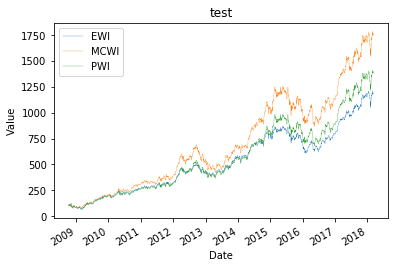

In [13]:
# Analysis

plt.figure(figsize=(40,30))
values_indexes.plot(y=['EWI','MCWI', 'PWI'], linewidth=.3)

plt.title(index_name)
plt.xlabel('Date')
plt.ylabel('Value')
#plt.legend(['Equally-Weighted','Cap-Weighted', 'Smart Beta','Smart Beta Var'])
plt.savefig('figure.pdf')

mean = np.mean(values_indexes.pct_change(252))
std = np.std(values_indexes.pct_change(252))
print('\033[1m' + '\nAnnualized Returns:\n' + '\033[0m' + str(mean))
print('\033[1m' + '\nAnnualized Standard Deviations:\n' + '\033[0m' + str(std))
print('\033[1m' + '\nAnnualized Sharpe-Ratio:\n' + '\033[0m' + str(mean/std))

In [14]:
#values_indexes.to_csv('export.csv', sep=',')
#returns_indexes.to_csv('export_returns.csv', sep=',')